### Custom Datasets and DataLoaders

In [1]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        im_nii_paths = sorted(glob(f"{root}/images/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/labels/*.nii"))
        
        self.ims, self.gts = self.get_slices(im_nii_paths, gt_nii_paths)
        self.transformations = transformations
        self.n_cls = 2
        
        assert len(self.ims) == len(self.gts)
        
    def __len__(self): return len(self.ims)

    def __getitem__(self, idx):
        
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        # For visualization purposes
        im = self.preprocess_im(im)
        # For the cases when label equals to 2; to avoid CE Loss error
        gt[gt > 1] = 1 
        
        return im.float(), gt.unsqueeze(0).long()
        
    def preprocess_im(self, im): 
        
        max_val = torch.max(im)
        im[im < 0] = 0
        
        return im / max_val
    
    def get_slices(self, im_nii_paths, gt_nii_paths): 
        
        ims, gts = [], []
        
        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            if index == 50: break
            print(f"nifti file number {index + 1} is being converted...")
            nii_im_data, nii_gt_data  = self.read_nii(im_nii, gt_nii)
            
            for idx, (im, gt) in enumerate(zip(nii_im_data, nii_gt_data)):
                if len(np.unique(gt)) == 2: ims.append(im); gts.append(gt)
        
        return ims, gts

    def read_nii(self, im, gt): return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)
    
    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/kaggle/input/3d-liver-and-liver-tumor-segmentation/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 16)

nifti file number 1 is being converted...
nifti file number 2 is being converted...
nifti file number 3 is being converted...
nifti file number 4 is being converted...
nifti file number 5 is being converted...
nifti file number 6 is being converted...
nifti file number 7 is being converted...
nifti file number 8 is being converted...
nifti file number 9 is being converted...
nifti file number 10 is being converted...
nifti file number 11 is being converted...
nifti file number 12 is being converted...
nifti file number 13 is being converted...
nifti file number 14 is being converted...
nifti file number 15 is being converted...
nifti file number 16 is being converted...
nifti file number 17 is being converted...
nifti file number 18 is being converted...
nifti file number 19 is being converted...
nifti file number 20 is being converted...
nifti file number 21 is being converted...
nifti file number 22 is being converted...
nifti file number 23 is being converted...
nifti file number 24

### Data Visualization

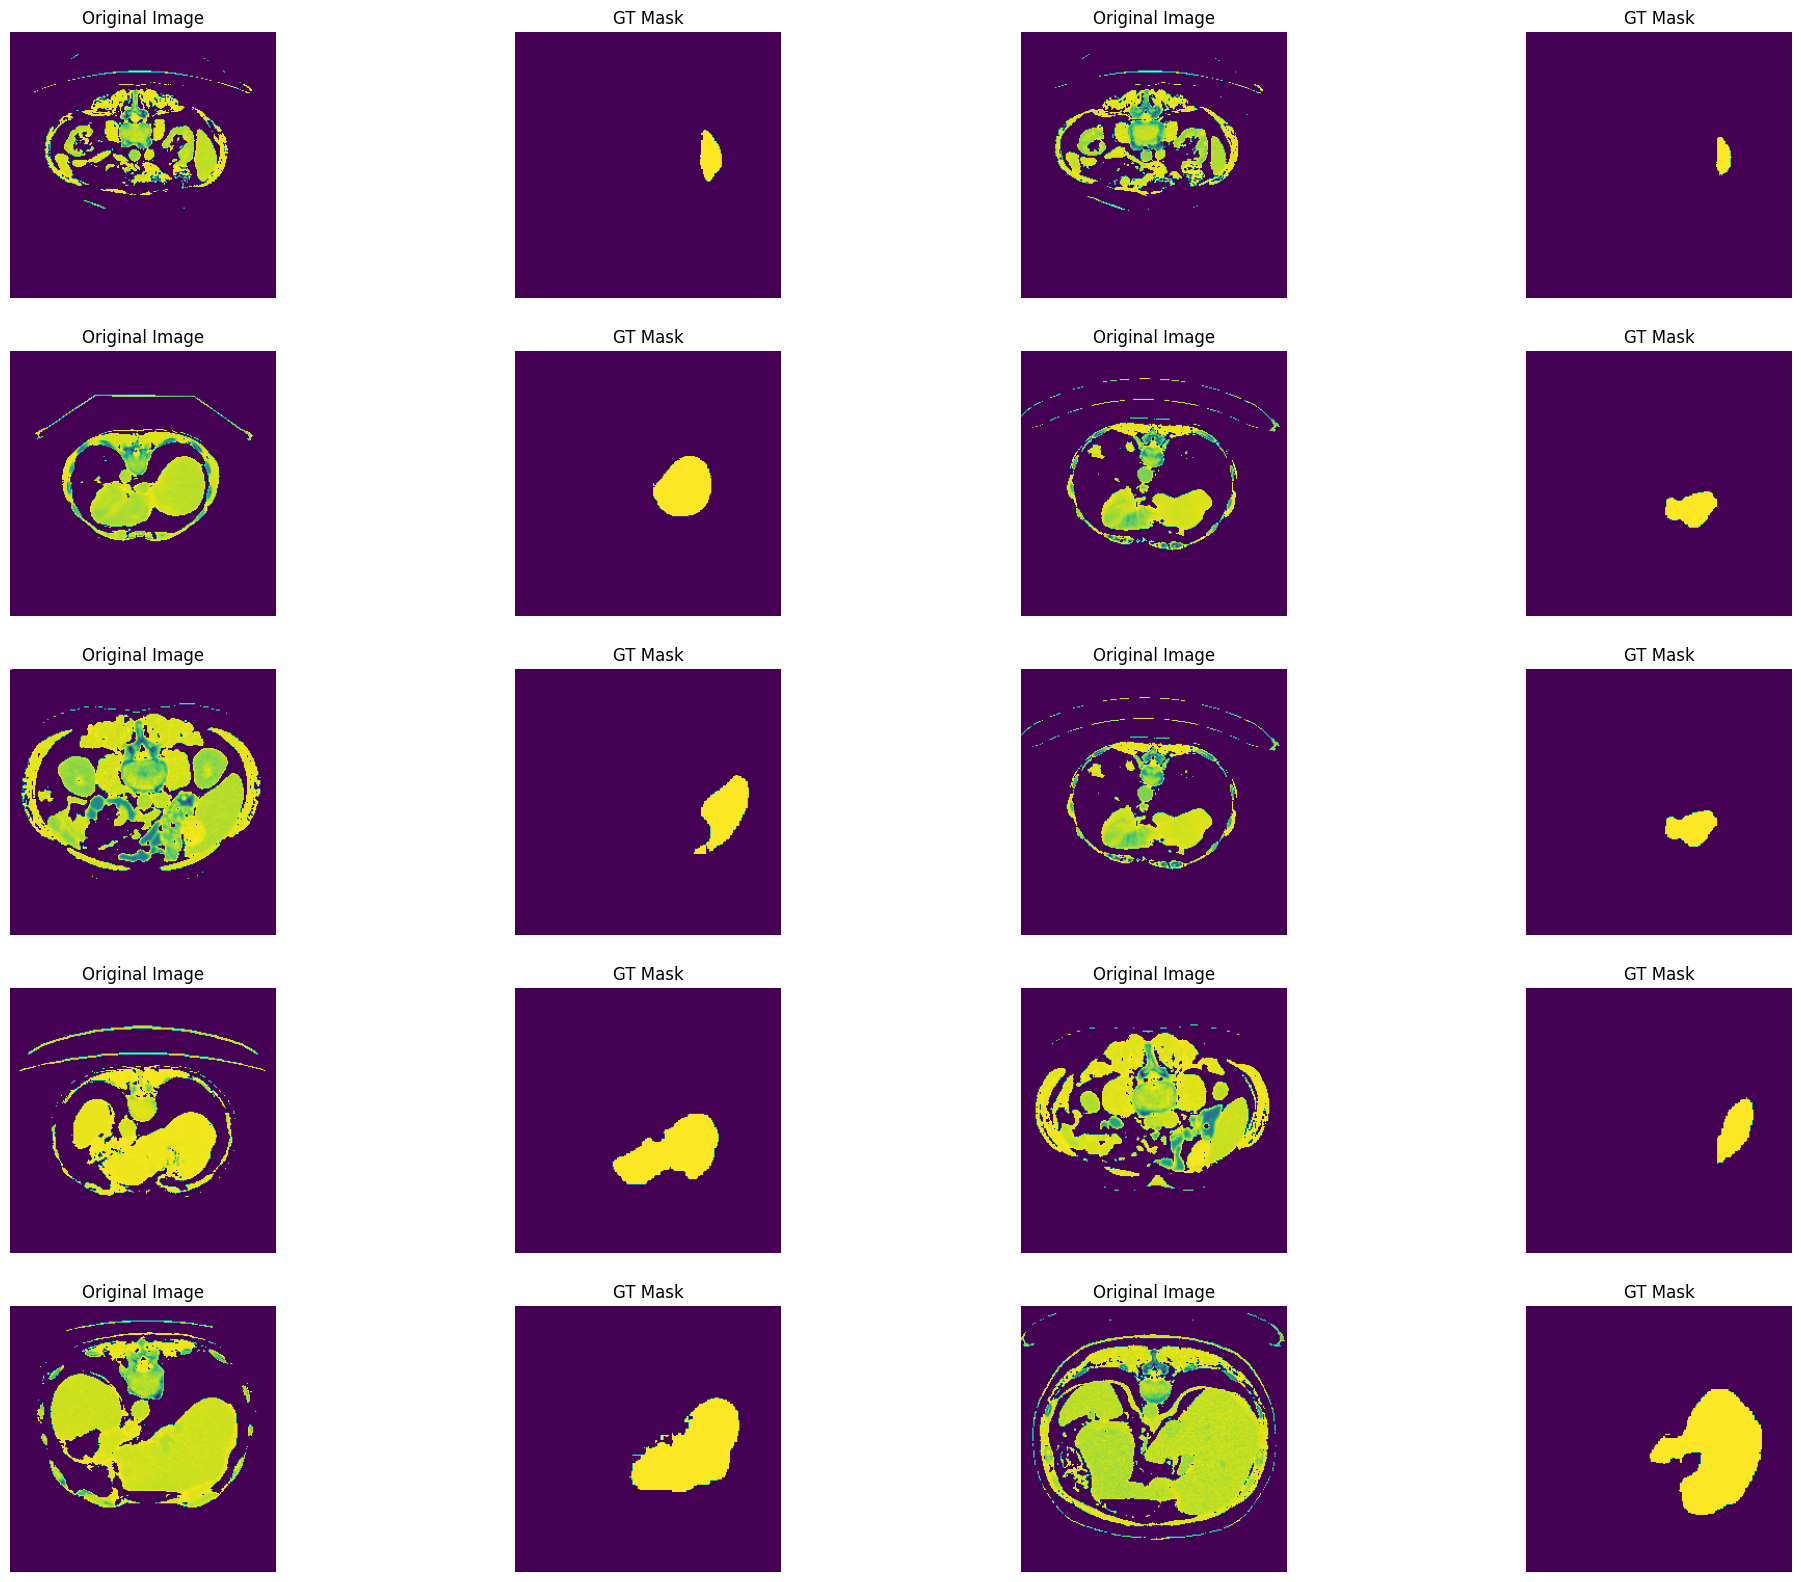

In [2]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8") * 255)
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        
        im, gt = ds[index]
    
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")
        
visualize(tr_dl.dataset, n_ims = 20)

### AI Model Train and Validation

In [14]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
import torch
import numpy as np
import time
 
# Define the number of classes
n_cls = 2


backbone = 'mobilenet_v2'  # Choose your desired backbone
model = smp.DeepLabV3Plus(
    encoder_name=backbone,
    encoder_weights='imagenet',
    in_channels=1,
    classes=n_cls,
)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

class Metrics():
    def __init__(self, pred, gt, loss_fn, eps=1e-10, n_cls=2):
        self.pred, self.gt = torch.argmax(pred, dim=1) > 0, gt  # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_, self.device = loss_fn, eps, n_cls, pred, device

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            iou_per_class = []
            for c in range(self.n_cls):
                match_pred = pred == c
                match_gt = gt == c
                if match_gt.long().sum().item() == 0:
                    iou_per_class.append(np.nan)
                else:
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, self.gt.squeeze(1))

def tic_toc(start_time=None): return time.time() if start_time == None else time.time() - start_time


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 80.3MB/s]


In [15]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, test_dl, loss_fn, opt, device, epochs, save_prefix, threshold=0.005, save_path="saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    test_loss, test_pa, test_iou = [], [], []
    tr_len, val_len, test_len = len(tr_dl), len(val_dl), len(test_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device).long()

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls=n_cls)
            loss_ = met.loss().requires_grad_()

            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls=n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                
        print(f"Epoch {epoch} test process is started...")
        test_loss_, test_iou_, test_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(test_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls=n_cls)

                test_loss_ += met.loss().item()
                test_iou_ += met.mIoU()
                test_pa_ += met.PA()
                
        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        test_loss_ /= test_len
        test_iou_ /= test_len
        test_pa_ /= test_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}")
        print(f"Test Loss          -> {test_loss_:.3f}")
        print(f"Test PA            -> {test_pa_:.3f}")
        print(f"Test IoU           -> {test_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        test_loss.append(test_loss_)
        test_iou.append(test_iou_)
        test_pa.append(test_pa_)
        
        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process because loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa,
            "test_loss": test_loss, "test_iou": test_iou, "test_pa" : test_pa}
device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,test_dl = test_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "liver")

Start training process...
Epoch 1 train process is started...


100%|██████████| 96/96 [00:13<00:00,  6.89it/s]


Epoch 1 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 11.16it/s]


Epoch 1 test process is started...


100%|██████████| 86/86 [00:01<00:00, 65.82it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 15.795 secs
Train Loss         -> 0.122
Train PA           -> 0.923
Train IoU          -> 0.839
Validation Loss    -> 0.046
Validation PA      -> 0.928
Validation IoU     -> 0.895
Test Loss          -> 0.043
Test PA            -> 0.988
Test IoU           -> 0.821

Loss decreased from inf to 0.046!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 96/96 [00:13<00:00,  6.91it/s]


Epoch 2 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 11.32it/s]


Epoch 2 test process is started...


100%|██████████| 86/86 [00:01<00:00, 65.58it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 15.739 secs
Train Loss         -> 0.031
Train PA           -> 0.932
Train IoU          -> 0.924
Validation Loss    -> 0.026
Validation PA      -> 0.926
Validation IoU     -> 0.939
Test Loss          -> 0.024
Test PA            -> 0.993
Test IoU           -> 0.900

Loss decreased from 0.046 to 0.026!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 96/96 [00:14<00:00,  6.78it/s]


Epoch 3 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 11.34it/s]


Epoch 3 test process is started...


100%|██████████| 86/86 [00:01<00:00, 62.41it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 16.083 secs
Train Loss         -> 0.021
Train PA           -> 0.933
Train IoU          -> 0.942
Validation Loss    -> 0.022
Validation PA      -> 0.926
Validation IoU     -> 0.941
Test Loss          -> 0.020
Test PA            -> 0.993
Test IoU           -> 0.894

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 96/96 [00:14<00:00,  6.81it/s]


Epoch 4 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 11.52it/s]


Epoch 4 test process is started...


100%|██████████| 86/86 [00:01<00:00, 66.23it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 15.933 secs
Train Loss         -> 0.016
Train PA           -> 0.933
Train IoU          -> 0.953
Validation Loss    -> 0.018
Validation PA      -> 0.925
Validation IoU     -> 0.951
Test Loss          -> 0.017
Test PA            -> 0.994
Test IoU           -> 0.919

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 96/96 [00:13<00:00,  6.92it/s]


Epoch 5 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 10.62it/s]


Epoch 5 test process is started...


100%|██████████| 86/86 [00:01<00:00, 66.54it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 15.754 secs
Train Loss         -> 0.013
Train PA           -> 0.933
Train IoU          -> 0.957
Validation Loss    -> 0.015
Validation PA      -> 0.925
Validation IoU     -> 0.957
Test Loss          -> 0.014
Test PA            -> 0.995
Test IoU           -> 0.927

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 96/96 [00:13<00:00,  6.94it/s]


Epoch 6 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 11.59it/s]


Epoch 6 test process is started...


100%|██████████| 86/86 [00:01<00:00, 64.44it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 15.708 secs
Train Loss         -> 0.012
Train PA           -> 0.933
Train IoU          -> 0.962
Validation Loss    -> 0.015
Validation PA      -> 0.925
Validation IoU     -> 0.955
Test Loss          -> 0.014
Test PA            -> 0.995
Test IoU           -> 0.926

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 96/96 [00:13<00:00,  6.90it/s]


Epoch 7 validation process is started...


100%|██████████| 6/6 [00:00<00:00, 11.48it/s]


Epoch 7 test process is started...


100%|██████████| 86/86 [00:01<00:00, 67.09it/s]

Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 15.737 secs
Train Loss         -> 0.012
Train PA           -> 0.933
Train IoU          -> 0.957
Validation Loss    -> 0.018
Validation PA      -> 0.927
Validation IoU     -> 0.946
Test Loss          -> 0.016
Test PA            -> 0.994
Test IoU           -> 0.874

Loss did not decrease for 5 epoch(s)!
Stopping training process because loss value did not decrease for 5 epochs!
Train process is completed in 1.848 minutes.


### Learning Curves

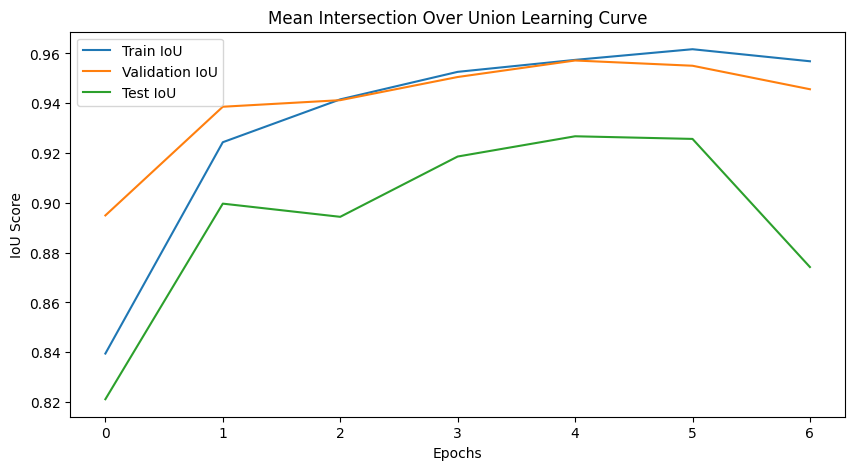

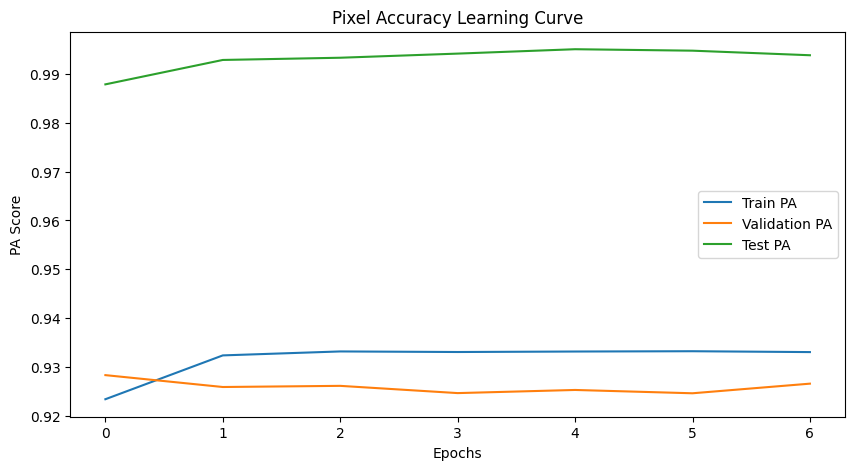

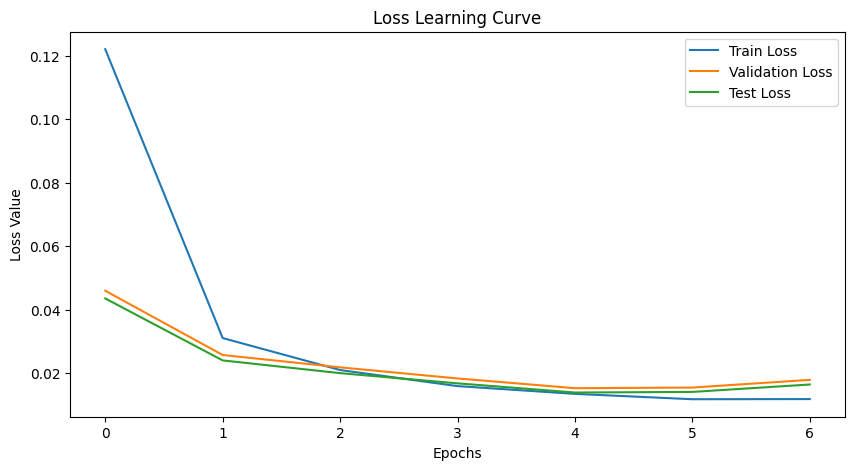

In [16]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1="tr_iou", metric2="val_iou", test_metric="test_iou",
                       label1="Train IoU", label2="Validation IoU", test_label="Test IoU",
                       title="Mean Intersection Over Union Learning Curve", ylabel="IoU Score")
    
        self.visualize(metric1="tr_pa", metric2="val_pa", test_metric="test_pa",
                       label1="Train PA", label2="Validation PA", test_label="Test PA",
                       title="Pixel Accuracy Learning Curve", ylabel="PA Score")
        
        self.visualize(metric1="tr_loss", metric2="val_loss", test_metric="test_loss",
                       label1="Train Loss", label2="Validation Loss", test_label="Test Loss",
                       title="Loss Learning Curve", ylabel="Loss Value")
        
        
    def plot(self, metric, label): 
        plt.plot(self.res[metric], label=label)
    
    def decorate(self, ylabel, title): 
        plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, test_metric, label1, label2, test_label, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1)
        self.plot(metric2, label2)
        self.plot(test_metric, test_label)  # Plotting test metric
        self.decorate(ylabel, title)                

# Assuming `history` contains the metrics dictionary returned by the `train` function
Plot(history)


### Inference and AI Model Performance Analysis 


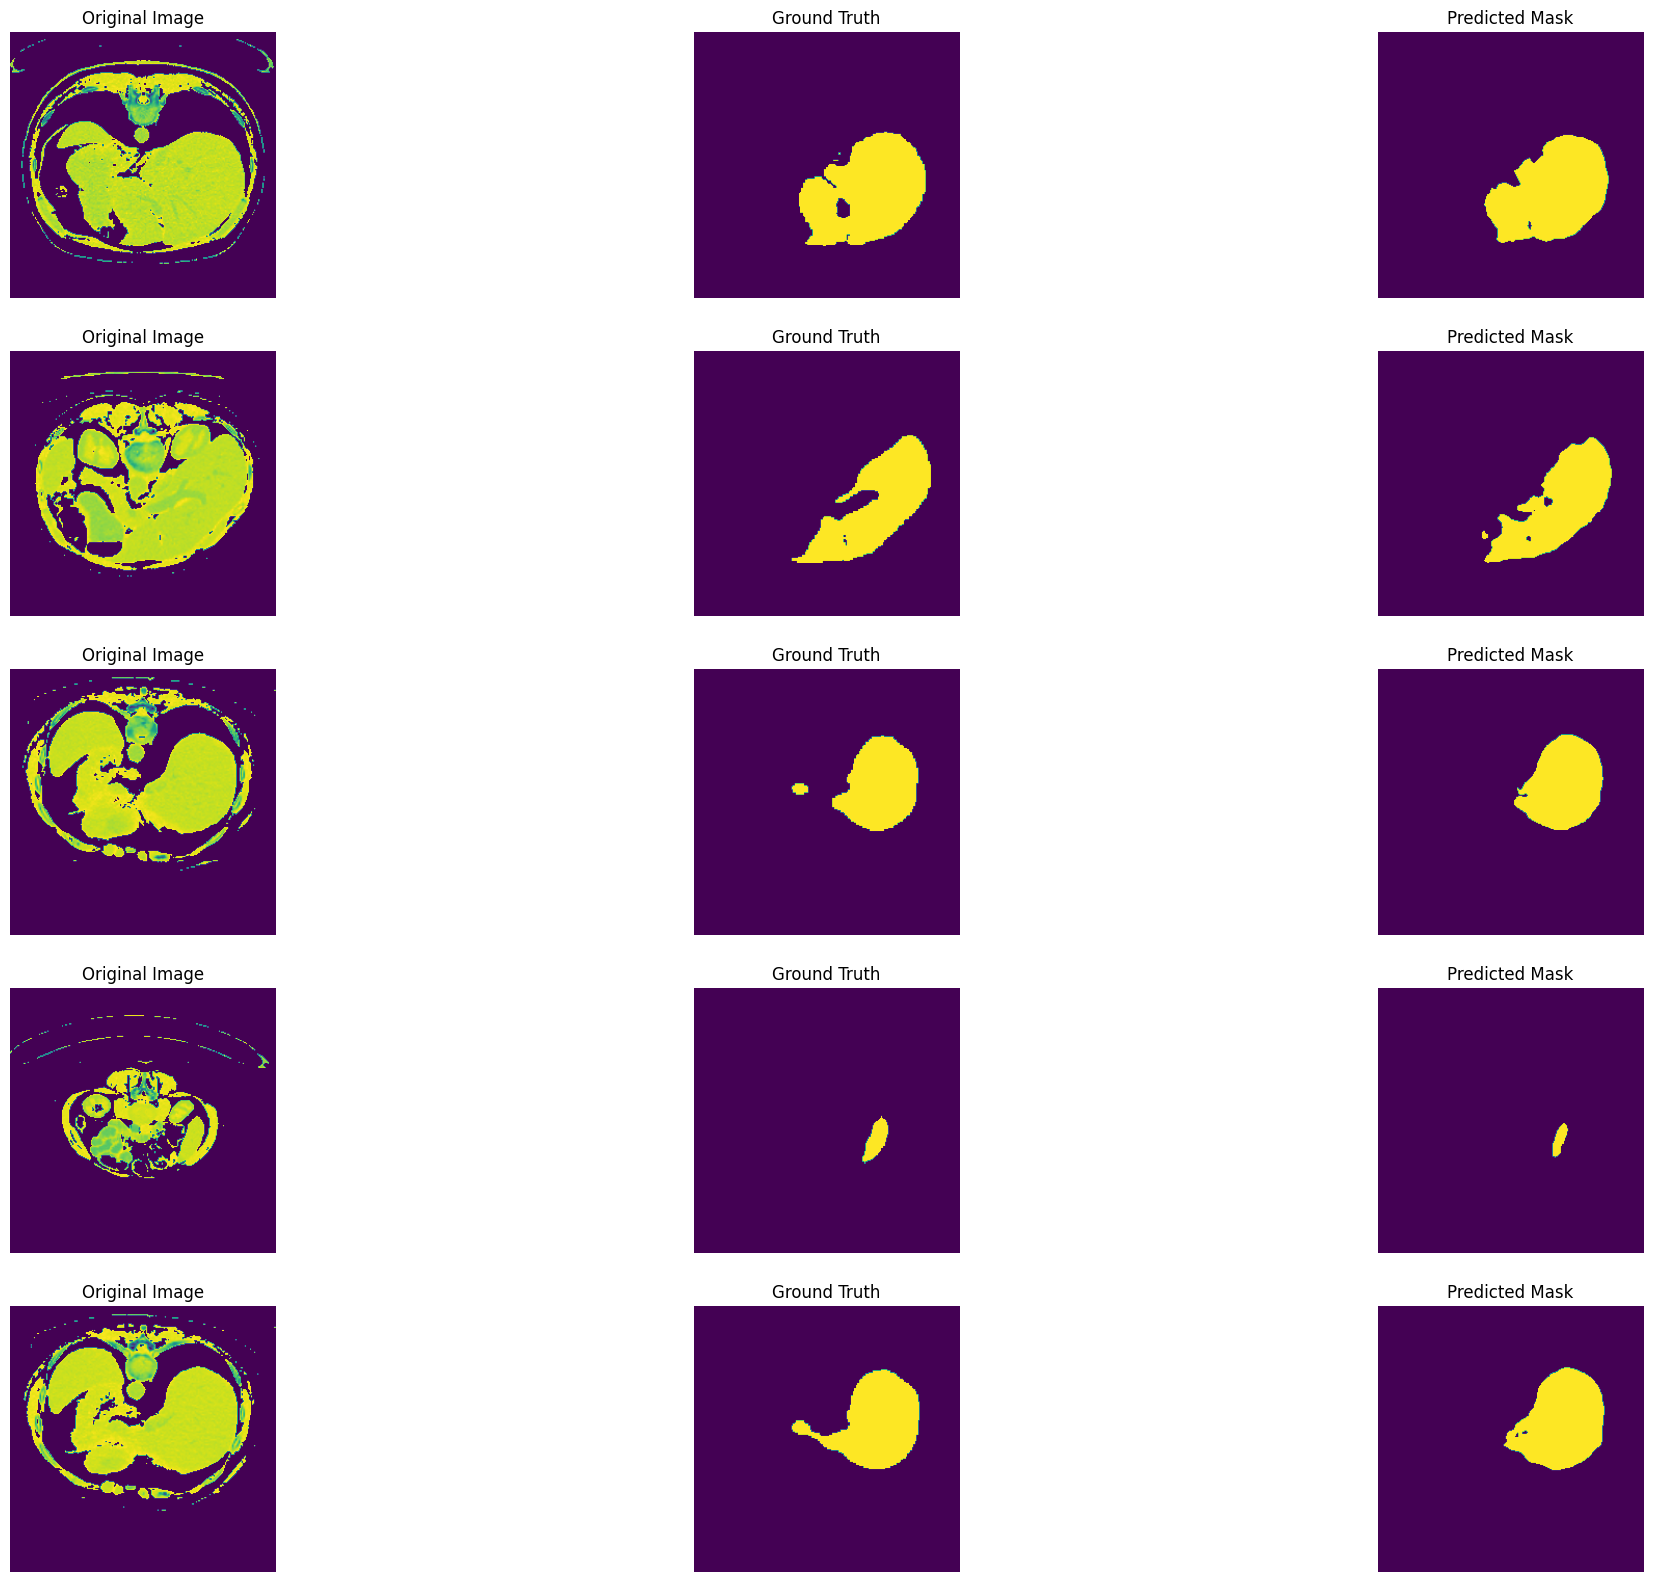

In [17]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        # First plot
        count = plot(cols, rows, count, im.squeeze(0))

        # Second plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")
        
model = torch.load("saved_models/liver_best_model.pt")
inference(test_dl, model = model, device = device)

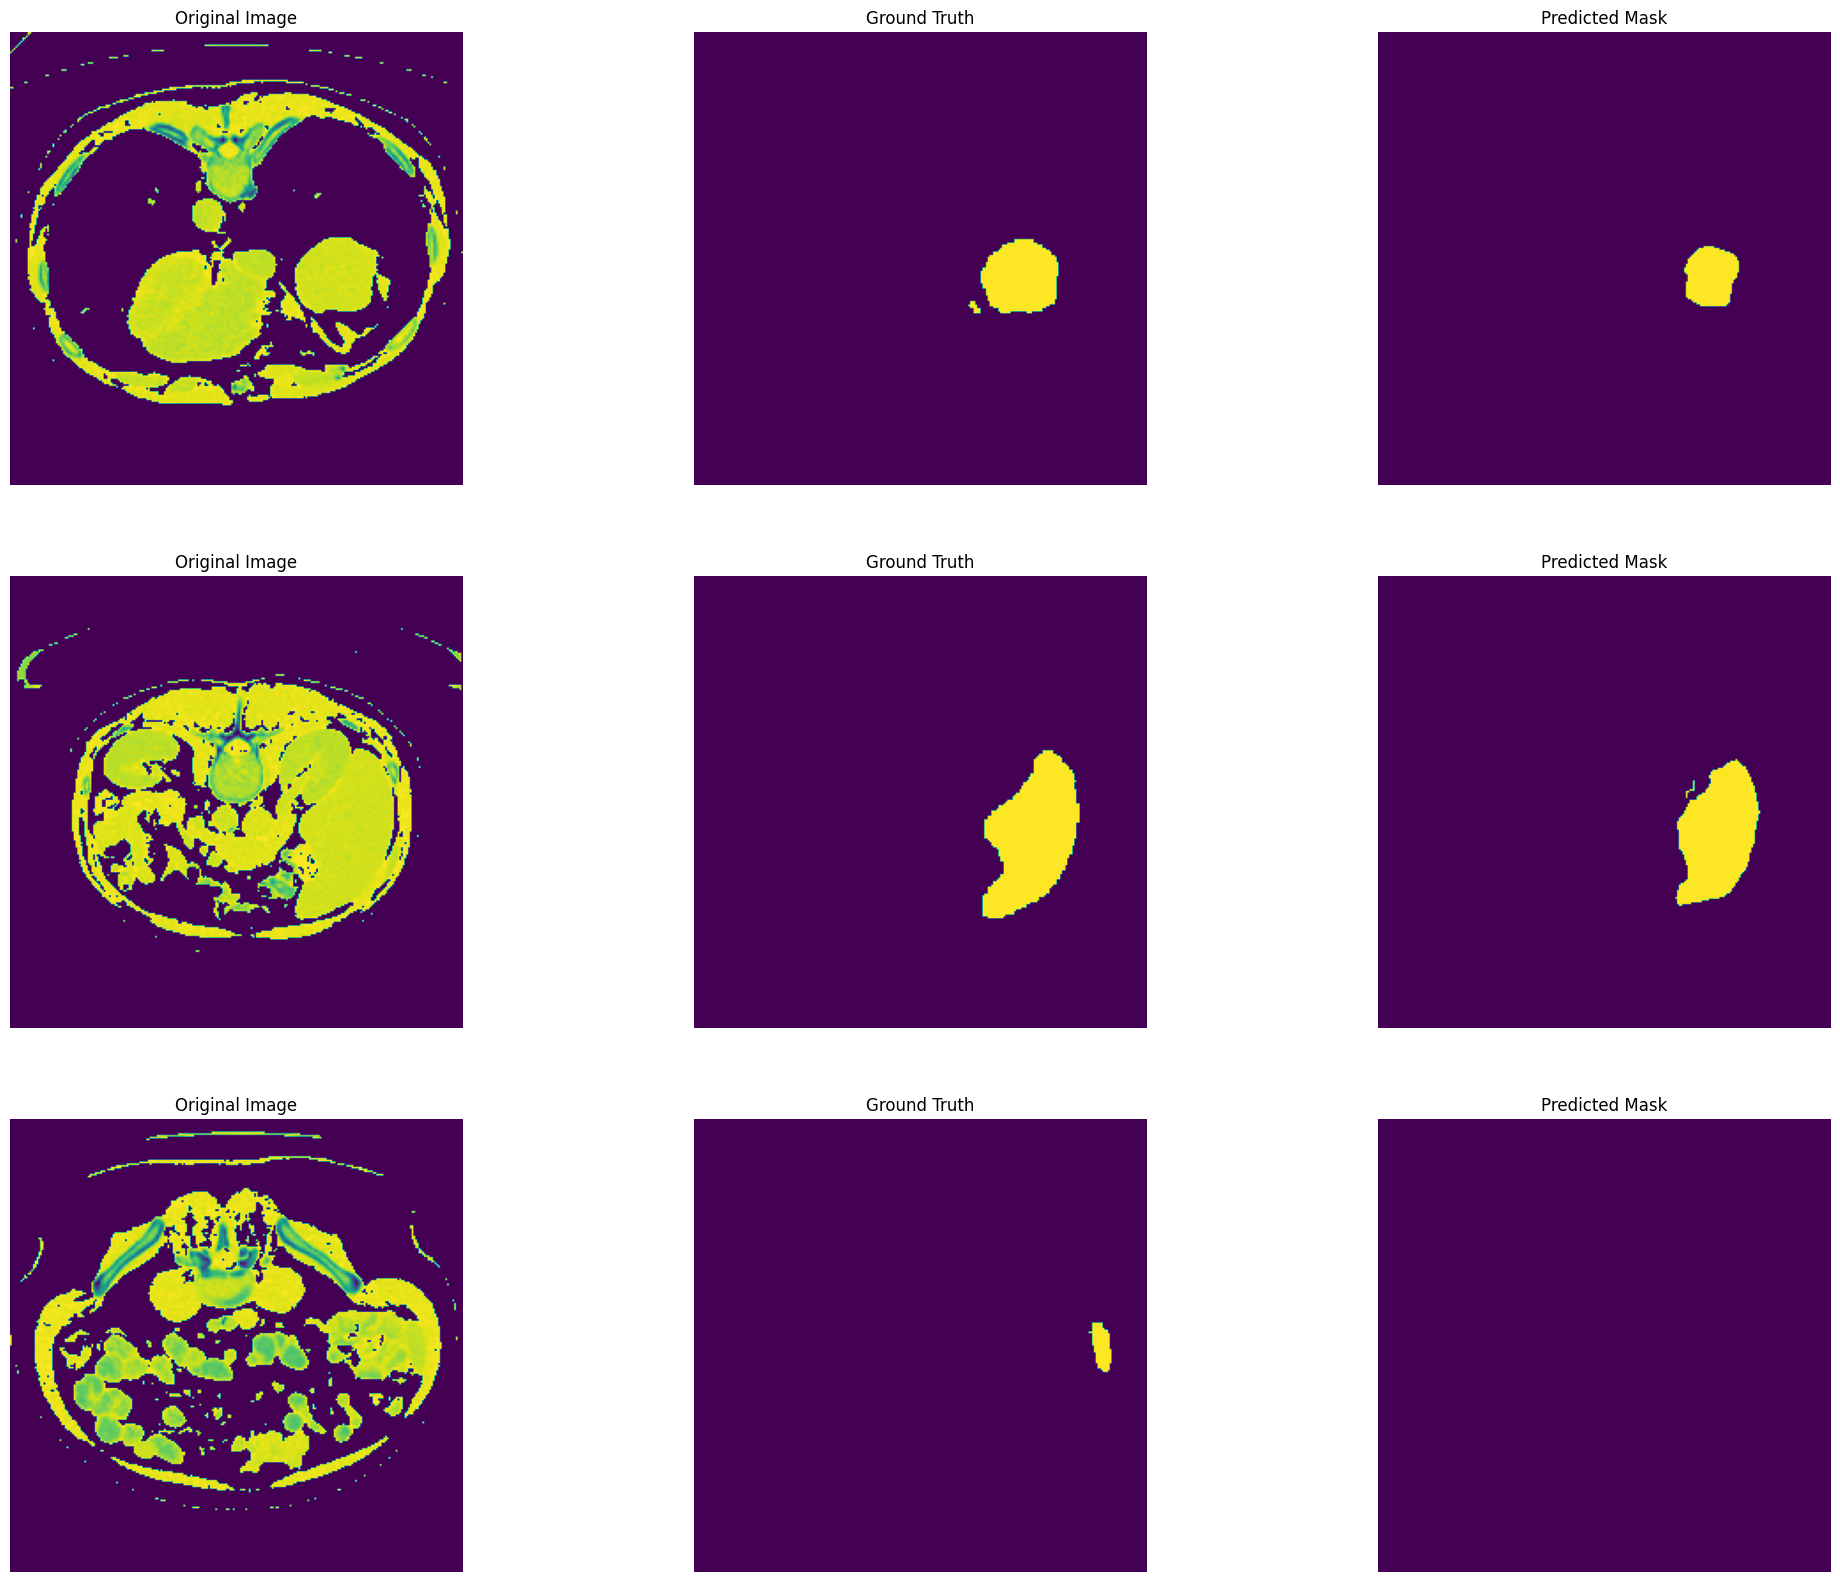

In [18]:
import random

def inference(dl, model, device, n_ims=10):
    
    cols = n_ims // 3
    rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    indices = random.sample(range(len(dl.dataset)), n_ims)
    
    for idx in indices:
        im, gt = dl.dataset[idx]

        # Get predicted mask
        with torch.no_grad(): 
            pred = torch.argmax(model(im.unsqueeze(0).to(device)), dim=1)
        
        ims.append(im)
        gts.append(gt)
        preds.append(pred)
        
    plt.figure(figsize=(25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im=pred, title="Predicted Mask")
model = torch.load("saved_models/liver_best_model.pt")
inference(test_dl, model = model, device = device)

In [ ]:
!pip install torchsummary
from torchsummary import summary


# Assuming your model is named 'model'
input_channels = 1  # Assuming grayscale images, adjust if necessary
input_height = 256  # Adjust based on your input image height
input_width = 256   # Adjust based on your input image width

# Print the summary
summary(model, input_size=(input_channels, input_height, input_width))